In [11]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html
import torch

device='cuda:1'

opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='vae_pix2pix2'
opt.netG='unet_2'
#opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all/'
#opt.dataset_mode='sathei'
opt.name='0110_vae_sathei_all'
opt.norm='batch'
opt.input_nc=1

opt.output_nc=3
opt.preprocess="none"
opt.epoch = 395
opt.attention = False
opt.useVAE2=True

opt.norm='instance'

print(opt)

model = create_model(opt)
model.setup(opt)
model.eval()
model=model.netG


----------------- Options ---------------
             aspect_ratio: 1.0                           
                attention: False                         
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: None                          
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 1                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
              

In [ ]:
import torch
import json
import random
import string
import pathlib
import base64
import re
from io import BytesIO
from PIL import Image
from flask import Flask, request, send_file, redirect, render_template, Response
from flask_socketio import SocketIO
import numpy as np

app = Flask(__name__)



def delete_img():
    folder = "static/result"
    images = os.listdir(folder)
    if len(images) >= 20:
        for image in images[:10]:
            os.remove(os.path.join(folder, image))

import torchvision
cs=256
cs2=cs**2
scale=0.06
bias_r=0.4
transform=torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.to(device)),
    torchvision.transforms.Lambda(lambda x: (x[0]-bias_r+x[1]/cs+x[2]/cs2).unsqueeze(0).unsqueeze(0)),
    
    ]
)

@app.route("/", methods=["GET"])
def index():
    return 'Server avaliable'

def getImage(base64string):
    return transform(Image.open(BytesIO(base64.b64decode(re.sub('^data:image/.+;base64,', '', base64string)))).convert("RGB"))

def tensor2im_24(v, imtype=np.uint8):
#     print(v.shape)
    v = torch.clamp(v.data[0][0]+ bias_r,min=0)
    v=torch.stack([v- ((v * cs) % 1) / cs , ((v * cs) % 1) - (((v * cs2) % 1) / cs), (v * cs2) % 1], dim=0)
    image_numpy = v.cpu().float().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0
    return image_numpy.astype(imtype)

def tensor2im(v, imtype=np.uint8):
    v = v.data[0]
    image_numpy = v.cpu().float().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0
    return image_numpy.astype(imtype)



@app.route("/generate", methods=["POST"])
def generate():
    global X,Y,latent,sat
    delete_img()
    path = "static/result"
    pathlib.Path('static/result').mkdir(parents=True, exist_ok=True)
    X = getImage(request.json['structure'])
    bias=(X.min()+X.max())/2
    X=(X-bias)/scale
    
    latent = torch.cat([getImage(request.json['latent'][i])for i in range(4)],dim=1)*50
    h, w=latent.shape[2],latent.shape[3]
    
    output = model(torch.cat([X,latent],dim=1))
    sat=torch.tanh(output[:,0:3])
    hei=output[:,3:4]
        
    hei_array = tensor2im_24(hei * scale + bias)
    hei_image = Image.fromarray(hei_array,"RGB")
    hei_name = ''.join(random.choice(string.ascii_lowercase) for i in range(6))+'.png'              
    hei_image.save(os.path.join(path, hei_name))
    
    sat_array = tensor2im(sat/2+0.5)
    sat_image = Image.fromarray(sat_array,"RGB")
    sat_name = ''.join(random.choice(string.ascii_lowercase) for i in range(6))+'.png'              
    sat_image.save(os.path.join(path, sat_name))
    
    resp = {
        'hei_path': path+'/'+hei_name,
        'sat_path': path+'/'+sat_name,
    }
    
    return Response(json.dumps(resp), mimetype="application/json")


socketio = SocketIO(app, cors_allowed_origins='*')
app.run(debug=False, host='0.0.0.0', port=81)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:81/ (Press CTRL+C to quit)
1.34.85.111 - - [11/Jan/2021 13:34:40] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:34:40] "GET /static/result/bayntc.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:34:40] "GET /static/result/ioivvg.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:34:44] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:34:44] "GET /static/result/oyvzag.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:34:44] "GET /static/result/pnxjnv.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:34:46] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:34:46] "GET /static/result/zpwbal.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:34:46] "GET /static/result/bcreys.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:34:46] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:34:46] "GET /static/result/nagdcm.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:34:46] "GET /static/result

1.34.85.111 - - [11/Jan/2021 13:35:05] "GET /static/result/nxsdih.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:05] "GET /static/result/qlvvjq.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:05] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:05] "GET /static/result/ydsgnv.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:05] "GET /static/result/ceself.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:06] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:06] "GET /static/result/sufprx.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:06] "GET /static/result/gwzpcv.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:06] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:06] "GET /static/result/seyzsu.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:06] "GET /static/result/wfapec.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:07] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021

1.34.85.111 - - [11/Jan/2021 13:35:23] "GET /static/result/twtdgs.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:24] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:24] "GET /static/result/vounwn.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:24] "GET /static/result/uymrdz.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:24] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:24] "GET /static/result/gpcycd.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:24] "GET /static/result/eintzq.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:25] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:25] "GET /static/result/vxnyol.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:25] "GET /static/result/bjkrti.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:26] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:26] "GET /static/result/mofwfx.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021

1.34.85.111 - - [11/Jan/2021 13:35:42] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:42] "GET /static/result/svjxma.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:43] "GET /static/result/ofdazp.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:43] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:43] "GET /static/result/edxmgg.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:43] "GET /static/result/cfjccp.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:44] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:44] "GET /static/result/dehoxh.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:45] "GET /static/result/eujdar.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:45] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:45] "GET /static/result/gcusis.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:35:45] "GET /static/result/qgcqfz.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021

1.34.85.111 - - [11/Jan/2021 13:38:19] "GET /static/result/idzjjb.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:20] "GET /static/result/fmuvfg.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:20] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:20] "GET /static/result/xtnrcs.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:20] "GET /static/result/huqacy.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:21] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:21] "GET /static/result/lhcnxy.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:21] "GET /static/result/oshysg.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:22] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:22] "GET /static/result/wkqrsb.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:22] "GET /static/result/mncldo.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:23] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021

1.34.85.111 - - [11/Jan/2021 13:38:56] "GET /static/result/eakmgy.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:59] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:38:59] "GET /static/result/aqitdo.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:39:00] "GET /static/result/stopgq.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:39:01] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:39:01] "GET /static/result/sbsdeh.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:39:01] "GET /static/result/bbhtwz.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:39:03] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:39:03] "GET /static/result/kurjpp.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:39:03] "GET /static/result/yzhmll.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:39:04] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:39:04] "GET /static/result/hukocd.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021

1.34.85.111 - - [11/Jan/2021 13:40:14] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:40:15] "GET /static/result/nluiie.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:40:15] "GET /static/result/hpbzqw.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:40:15] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:40:15] "GET /static/result/uognxu.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:40:15] "GET /static/result/vfwymz.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:40:16] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:40:16] "GET /static/result/opnlkf.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:40:16] "GET /static/result/reskmw.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:40:16] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:40:16] "GET /static/result/szakqm.png HTTP/1.1" 200 -
1.34.85.111 - - [11/Jan/2021 13:40:17] "GET /static/result/ezuhcs.png HTTP/1.1" 200 -


In [11]:
plt.imshow(Y[0, 0].cpu().detach())
plt.colorbar()

NameError: name 'plt' is not defined

In [2]:
opt

Namespace(aspect_ratio=1.0, attention=False, batch_size=1, checkpoints_dir='./checkpoints', crop_size=256, dataroot=None, dataset_mode='single', direction='AtoB', display_id=-1, display_winsize=256, epoch=245, eval=False, gpu_ids=[1], init_gain=0.02, init_type='normal', input_nc=1, isTrain=False, load_iter=0, load_size=256, max_dataset_size=inf, model='vae_pix2pix2', model_suffix='', mult_skip_conn=False, n_layers_D=3, name='0110_vae_sathei_all', ndf=64, netD='basic', netG='unet_2', ngf=64, no_dropout=False, no_flip=True, norm='batch', ntest=inf, num_test=50, num_threads=0, output_nc=3, phase='test', preprocess='none', results_dir='./results/', serial_batches=True, suffix='', useVAE2=True, verbose=False)

In [13]:
plt.imshow(hei_model(torch.cat([X*1,up(latent_hei[5])*0],dim=1))[0,0].cpu().detach())
plt.colorbar()

NameError: name 'up' is not defined

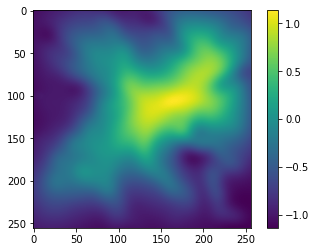

In [27]:
import matplotlib.pyplot as plt
plt.imshow(X[0,0].cpu().detach())
plt.colorbar()

In [20]:
up=torch.nn.Upsample(size=[256,256])

In [153]:
(sat.min(),sat.max())

(tensor(-0.9618, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.8859, device='cuda:0', grad_fn=<MaxBackward1>))

In [3]:
(torch.mm(U.t(),latent[a:a+d].t().cpu().double())).t().shape

NameError: name 'latent' is not defined

In [33]:
import torch
latent_hei=torch.load('latent_data/lat10')

In [33]:
(latent-latent.mean(0))

tensor([-9.7228e-02,  4.5485e-02, -2.5228e-01, -1.3564e-01, -2.3248e-02,
        -7.8469e-02,  1.7260e-02,  8.1414e-02, -6.4035e-02, -1.0142e-01,
        -1.2557e-03, -1.4185e-01, -5.5843e-02,  1.4802e-01, -4.2049e-02,
        -9.7208e-02, -2.4463e-02,  7.7214e-01,  1.2428e+00, -5.3769e-01,
        -1.0978e+00,  1.3108e+00, -1.3921e+00,  1.0719e+00,  5.3930e-01,
        -5.8487e-01,  1.0161e+00, -1.6145e-01,  4.7305e-01, -3.0348e-01,
        -8.4524e-01,  4.5087e-01], device='cuda:0')

In [10]:
plt.imshow(U)
plt.colorbar()

NameError: name 'plt' is not defined

In [4]:
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='vae_pix2pix'
opt.netG='unet_256'
opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all/'
opt.dataset_mode='aligned'
opt.name='1026_vae_sat_all'
opt.norm='batch'
opt.input_nc=1
opt.output_nc=3
opt.preprocess=[]
sat_model = create_model(opt)
sat_model.setup(opt)

opt.phase='train'
train_dataset = create_dataset(opt)


initialize network with normal
model [VAEPix2PixModel] was created
loading the model from ./checkpoints/1026_vae_sat_all/latest_net_S.pth
loading the model from ./checkpoints/1026_vae_sat_all/latest_net_G.pth
---------- Networks initialized -------------
[Network S] Total number of parameters : 2.956 M
[Network G] Total number of parameters : 54.428 M
-----------------------------------------------
dataset [AlignedDataset] was created


In [5]:
torch.load('latent_data/mean_and_pca')

(tensor([-9.7228e-02,  4.5485e-02, -2.5228e-01, -1.3564e-01, -2.3248e-02,
         -7.8469e-02,  1.7260e-02,  8.1414e-02, -6.4035e-02, -1.0142e-01,
         -1.2557e-03, -1.4185e-01, -5.5843e-02,  1.4802e-01, -4.2049e-02,
         -9.7208e-02, -2.4463e-02,  7.7214e-01,  1.2428e+00, -5.3769e-01,
         -1.0978e+00,  1.3108e+00, -1.3921e+00,  1.0719e+00,  5.3930e-01,
         -5.8487e-01,  1.0161e+00, -1.6145e-01,  4.7305e-01, -3.0348e-01,
         -8.4524e-01,  4.5087e-01], device='cuda:0'),
 tensor([[-2.8590e-04,  7.4155e-04, -1.8919e-03, -1.0745e-03, -2.6615e-04,
           3.1679e-04, -9.2807e-04, -1.9652e-04, -9.1979e-06,  1.2728e-03],
         [-4.9969e-05, -3.5608e-03,  6.7265e-03,  3.7181e-03,  1.4317e-03,
          -1.2793e-03,  2.4091e-03,  1.4536e-03,  1.0665e-03, -1.7452e-03],
         [ 1.4359e-01,  1.7924e-01,  6.0120e-01, -2.4677e-02, -4.3563e-01,
          -1.5963e-02, -1.4013e-01, -1.1598e-01,  2.2241e-01, -2.7973e-01],
         [-2.6112e-03, -1.1537e-03, -2.7220e-02, 

In [9]:
[torch.mean(latent.t()[i])for i in range(32)]

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [134]:
torch.var(torch.tensor([[1,2.]]))

tensor(0.5000)

14432664.319664817


In [18]:
model.netS.module.upsampler(latent[0][0:16].view(1,1,4,4)).shape

NameError: name 'model' is not defined

In [19]:
slider = torch.tensor([[0.]*10]).float()
slider[0,0] = 1
slider[0,1] = -1
latent = torch.mm(U,slider.t())


In [119]:
14432664

0.30000000000000004

In [212]:
model.forward(latent)

tensor([[0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], dtype=torch.float64)

In [18]:
i=1099511627776
a=0
while i>1:
    i/=2
    a+=1
a

40

In [18]:
import torch
model.set_input(data)
model.forward(torch.tensor([[-0.0010],
        [ 0.5],
        [-0.0356],
        [-0.0015],
        [-0.0081],
        [ 0.0255],
        [0.3],
        [ 0.0295],
        [-0.0169],
        [-0.0107],
        [ 0.1654],
        [0.5],
        [ 0.0121],
        [-0.3842],
        [ 0.0416],
        [ 0.3695]]*16, dtype=torch.float).cuda())

In [22]:
import torchvision
def p(x):
    return torchvision.transforms.ToPILImage()(x[0].detach().cpu()/2+0.5)

In [23]:
p(model.get_current_visuals()['fake_B'])

NameError: name 'model' is not defined

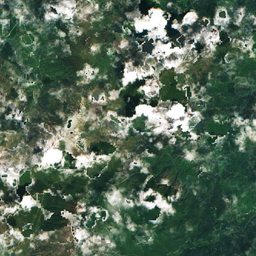

In [254]:
p(model.get_current_visuals()['real_B'])

In [25]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html

opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='vae_pix2pix'
opt.netG='unet_256'
opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all/'
opt.dataset_mode='aligned'
opt.name='1026_vae_sat_all'
opt.norm='batch'
opt.input_nc=1
opt.output_nc=3
opt.preprocess=[]
sat_model = model.create_model(opt)
sat_model.setup(opt)

opt.phase='train'
train_dataset = create_dataset(opt)
opt.phase='val'
val_dataset = create_dataset(opt)
opt.phase='test'
test_dataset = create_dataset(opt)
from tqdm import tqdm
mius_sat=[]
model=sat_model
model.eval()

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: None                          
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                             	[default: 0]
 

NameError: name 'model' is not defined

In [21]:
U

NameError: name 'U' is not defined